# 线性回归的从零开始实现
* 只利用tensor和autograd来实现一个线性回归的训练

In [1]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random


### 生成数据集

In [2]:
# 特征数为2
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
# 生成数据服从标准分布
features = torch.randn(num_examples, num_inputs,
                       dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
# 添加噪声， 正态分布的噪声
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
                       dtype=torch.float32)


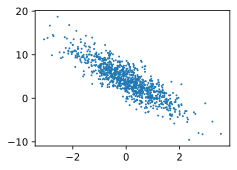

In [3]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

# # 在../d2lzh_pytorch里面添加上面两个函数后就可以这样导入
# import sys
# sys.path.append("..")
# from d2lzh_pytorch import * 

set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);


### 读取数据

In [5]:
# 定义函数每次返回batch_size个随机样本的特征和标签
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices) #样本读取顺序设置为随机
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i+batch_size, num_examples)])
        yield features.index_select(0, j), labels.index_select(0, j)
        

In [6]:
# 读取第一个小批量数据
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[ 1.0675, -0.2440],
        [ 0.7521,  0.5860],
        [ 1.1545, -0.8189],
        [-2.1001, -0.1196],
        [-1.4661, -0.4634],
        [-0.6849,  0.3262],
        [ 0.0052,  0.7979],
        [ 1.9846,  0.2772],
        [ 0.2473,  1.6545],
        [-2.3304, -1.6133]]) tensor([ 7.1634,  3.7166,  9.3062,  0.4069,  2.8576,  1.7350,  1.4918,  7.2161,
        -0.9280,  5.0314])


### 初始化模型参数

In [7]:
# 我们将权重初始化成均值为0、标准差为0.01的正态随机数，偏差则初始化成0。
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)


tensor([0.], requires_grad=True)

### 定义模型

In [8]:
def linreg(X, w, b):
    # 用mm函数做矩阵乘法
    return torch.mm(X, w) + b

### 定义损失函数

In [9]:
def squared_loss(y_hat, y):  
    # 注意这里返回的是向量, 另外, pytorch里的MSELoss并没有除以 2
    return (y_hat - y.view(y_hat.size())) ** 2 / 2


### 定义优化算法

In [11]:
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr*param.grad / batch_size

### 训练模型

In [12]:
# 学习率
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数

        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))


epoch 1, loss 0.042974
epoch 2, loss 0.000170
epoch 3, loss 0.000051


In [13]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 2.0001],
        [-3.3996]], requires_grad=True)
4.2 
 tensor([4.1997], requires_grad=True)


* 可以看出训练得出的特征值值和真实值很接近了